## beta_d | beta_t 参数调整

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc

In [18]:
BASE_DIR = os.path.abspath('output')
def load_para(dataset):
    paras = []
    BASE_DIR = os.path.abspath('output')
    print BASE_DIR
    file_dir = os.path.join(BASE_DIR, dataset)
    ListDIR = os.listdir(BASE_DIR)
    
    for para in ListDIR:
        if para.find(dataset) > -1:
            if para.find('npz') > -1:
                try:
                    paras.append(np.load(os.path.join(BASE_DIR, para)))
                finally:
                    print 'ok'
            print para
            try:
                paras.append(np.loadtxt(os.path.join(BASE_DIR, para), delimiter=',', encoding='utf-8'))
            finally:
                print "okok"
    return paras
    
# load_para('_e')
dt_name = np.load(os.path.join(BASE_DIR, 'dt_name_e.npz'))
intMat = np.loadtxt(os.path.join(BASE_DIR, 'intMat_e'), delimiter=',')
drugMat = np.loadtxt(os.path.join(BASE_DIR, 'drugMat_e'), delimiter=',')
targetMat = np.loadtxt(os.path.join(BASE_DIR, 'targetMat_e'), delimiter=',')
method = "netlaprls"
print intMat.shape

(445, 664)


In [23]:
class NetLapRLS:
    def __init__(self, gamma_d=10, gamma_t=10, beta_d=1e-5, beta_t=1e-5):
        self.gamma_d = float(gamma_d)
        self.gamma_t = float(gamma_t)
        self.beta_d = float(beta_d)
        self.beta_t = float(beta_t)

    def fix_model(self, W, intMat, drugMat, targetMat, seed=None):
        R = W*intMat
        m, n = R.shape
        # print m,n
        # 修正similarity matrix --> symmetric matrix
        drugMat = (drugMat + drugMat.T)/2.
        targetMat = (targetMat + targetMat.T)/2.

        # 药物相似度矩阵
        Wd = (drugMat+self.gamma_d*np.dot(R, R.T)) / (1.0+self.gamma_d)
        Wt = (targetMat+self.gamma_t*np.dot(R.T, R)) / (1.0+self.gamma_t)
        # 去除主对角线上自身的评分e
        Wd = Wd-np.diag(np.diag(Wd))
        Wt = Wt-np.diag(np.diag(Wt))
        # D是一个wd的按照列相加 得到的为列表 长度为drug 开根号 的对角矩阵  D=Dd^(-1/2)
        ## Dd节点的度矩阵
        # RuntimeWarning: divide by zero encountered in divide
        Wd_srow = np.sum(Wd, axis=1, dtype=np.float64)
        # Wd_srow[np.where(Wd_srow == 0)] == 0.00001
        D = np.diag(1.0/np.sqrt(Wd_srow))
        Ld = np.eye(m) - np.dot(np.dot(D, Wd), D)  # Ld = Indxnd - DwdD

        # 将 0 -> 0.00001
        Wt_srow = np.sum(Wt, axis=1, dtype=np.float64)
        # Wt_srow[np.where(Wt_srow == 0)] = 0.00001

        # print np.where(Wt_srow == 0)  # 检查np.sum(Wt,axis=1))是否有0

        D = np.diag(1.0/np.sqrt(Wt_srow))
        Lt = np.eye(n) - np.dot(np.dot(D, Wt), D)

        # np.linalg为行业标准级fortran库  inv求矩阵的逆  X = (wd + beta_d*wd)^(-1)
        X = np.linalg.inv(Wd+self.beta_d*np.dot(Ld, Wd))
        Fd = np.dot(np.dot(Wd, X), R)
        X = np.linalg.inv(Wt+self.beta_t*np.dot(Lt, Wt))
        Ft = np.dot(np.dot(Wt, X), R.T)
        self.predictR = 0.5*(Fd+Ft.T)

    def predict_scores(self, test_data, N):
        inx = np.array(test_data)
        return self.predictR[inx[:, 0], inx[:, 1]]

    def evaluation(self, test_data, test_label):
        scores = self.predictR[test_data[:, 0], test_data[:, 1]]
        prec, rec, thr = precision_recall_curve(test_label, scores)
        aupr_val = auc(rec, prec)
        fpr, tpr, thr = roc_curve(test_label, scores)
        auc_val = auc(fpr, tpr)
        return aupr_val, auc_val

    def __str__(self):
        return "Model: NetLapRLS, gamma_d:%s, gamma_t:%s, beta_d:%s, beta_t:%s" \
               % (self.gamma_d, self.gamma_t, self.beta_d, self.beta_t)
    
    
 # cv的模式cv1 cv2 cv3
def cross_validation(intMat, seeds=[22,], cv=1, num=10):
    cv_data = defaultdict(list)
    # print cv_data
    for seed in seeds:
        num_drugs, num_targets = intMat.shape
        prng = np.random.RandomState(seed)
        if cv == 0:
            index = prng.permutation(num_drugs)
        if cv == 1:
            index = prng.permutation(intMat.size)
        step = index.size/num
        for i in xrange(num):
            if i < num-1:
                ii = index[i*step:(i+1)*step]
            else:
                ii = index[i*step:]
            if cv == 0:
                test_data = np.array([[k, j] for k in ii for j in xrange(num_targets)], dtype=np.int32)
            elif cv == 1:
                test_data = np.array([[k/num_targets, k % num_targets] for k in ii], dtype=np.int32)
            x, y = test_data[:, 0], test_data[:, 1]
            test_label = intMat[x, y]
            W = np.ones(intMat.shape)
            W[x, y] = 0
            cv_data[seed].append((W, test_data, test_label))
    return cv_data
   
# 训练模型
def train(model, cv_data, intMat, drugMat, targetMat):
    aupr, auc = [], []
    for seed in cv_data.keys():
        for W, test_data, test_label in cv_data[seed]:
            model.fix_model(W, intMat, drugMat, targetMat, seed)
            aupr_val, auc_val = model.evaluation(test_data, test_label)
            aupr.append(aupr_val)
            auc.append(auc_val)
    return np.array(aupr, dtype=np.float64), np.array(auc, dtype=np.float64)


def mean_confidence_interval(data, confidence=0.95):
    import scipy as sp
    import scipy.stats
    a = 1.0*np.array(data)
    n = len(a)
    # sem 计算标准误差
    m, se = np.mean(a), scipy.stats.sem(a)
    # ppf 分位点函数
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, h

# cv_data = cross_validation(intMat, [22,], cv=1, num=10)
# netlaprls_cv_eval('netlaprls', cv_data, intMat, drugMat, targetMat, cvs=1 )

In [20]:
def netlaprls_cv_eval_1(method, dataset, cv_data, intMat, drugMat, targetMat):
    max_auc, auc_opt = 0, []
    for x in np.logspace(-6, 3, 10):  # [-6, 2]
        for y in np.logspace(-6, 3, 10):  # [-6, 2]
            tic = time.clock()
            model = NetLapRLS(gamma_d=10, gamma_t=10, beta_d=x, beta_t=y)
            cmd = "Dataset:"+dataset+" CVS: "+str(cvs)+"\n"+str(model)
            print cmd
            aupr_vec, auc_vec = train(model, cv_data, X, D, T)
            aupr_avg, aupr_conf = mean_confidence_interval(aupr_vec)
            auc_avg, auc_conf = mean_confidence_interval(auc_vec)
            print "auc:%.6f, aupr: %.6f, auc_conf:%.6f, aupr_conf:%.6f, Time:%.6f\n" % (auc_avg, aupr_avg, auc_conf, aupr_conf, time.clock()-tic)
            if auc_avg > max_auc:
                max_auc = auc_avg
                auc_opt = [cmd, auc_avg, aupr_avg, auc_conf, aupr_conf]
    cmd = "Optimal parameter setting:\n%s\n" % auc_opt[0]
    cmd += "auc: %.6f, aupr: %.6f, auc_conf:%.6f, aupr_conf:%.6f\n" % (auc_opt[1], auc_opt[2], auc_opt[3], auc_opt[4])

In [35]:
%matplotlib inline
def netlaprls_cv_eval(cv_data, intMat, drugMat, targetMat):
    max_auc, auc_opt = 0, []
    # meshgrid 
    beta_ds = np.logspace(-6,3,10)
    beta_ts = np.logspace(-6,3,10)
    scores = []
    for beta_d in beta_ds: 
        for beta_t in beta_ts:
            model = NetLapRLS(beta_d=beta_d, beta_t=beta_t)
            aupr_vec, auc_vec = train(model, cv_data, intMat, drugMat, targetMat)
            aupr_avg, aupr_conf = mean_confidence_interval(aupr_vec)
            auc_avg, auc_conf = mean_confidence_interval(auc_vec)
            scores.append([auc_avg, aupr_avg])
            print 'current beta_t %f ----- current beta_d %f -- apur: %f , auc: %f' %(beta_t, beta_d, aupr_avg, auc_avg)
            
    np.savetxt('aupr_auc_avg', scores, delimiter=',', fmt='%.8f') 
    # plot
    beta_ds, beta_ts = np.meshgrid(beta_ds, beta_ts)
    scores_d = np.array(scores[:,0]).reshape(beta_ds.shape)
    scores_t = np.array(scores[:,1]).reshape(beta_dt.shape)
    plt.contourf(beta_ds, beta_ts, scores_d, 9, alpha=0.75, cmap=plt.cm.hot)
    C = plt.contour(beta_ds, beta_ts, scores_d, 9, colors="black", linewidth=5)
    plt.show()

# cv_data = cross_validation(intMat)
# netlaprls_cv_eval(cv_data, intMat, drugMat, targetMat)

[1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


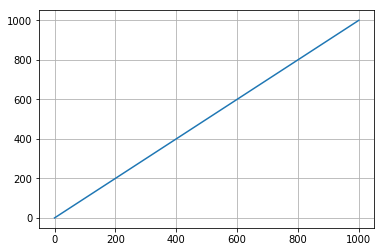

In [49]:
#matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
beta_ds = np.logspace(-6,3,10)
beta_ts = np.logspace(-6,3,10)
scores = np.loadtxt('aupr_auc_avg', delimiter=',')
# beta_ds, beta_ts = np.meshgrid(beta_ds, beta_ts)
# scores_d = np.array(scores[:,0]).reshape(beta_ds.shape)
# scores_t = np.array(scores[:,1]).reshape(beta_ds.shape)
print beta_ds
plt.plot(beta_ds, beta_ts)
# print scores_d
# print scores_t
plt.show()

In [73]:
n = 256
x = np.linspace(-3,3,n)
y = np.linspace(-3,3,n)
X,Y = np.meshgrid(x,y)
plt.contourf(X,Y,f(X,Y), 8, alpha=0.75, cmap=plt.cm.hot)

C = plt.contour(X,Y,f(X, Y), 8, colors='black', linewidth=5)
plt.xticks()
plt.yticks()
plt.show()

NameError: name 'f' is not defined

In [111]:
prng = np.random.RandomState(22)
print intMat.size
index = prng.permutation(intMat.size)
print index
step = index.size/10
print step

295480
[231556 215777 188854 ...  24932 162752 252036]
29548


In [151]:
ii = index[0:step]
test_data = np.array([[k/664, k%664] for k in ii])
print test_data.shape
x, y  = test_data[:,0], test_data[:,1]
print x.shape, y.shape
test_label = intMat[x, y]
print test_label
W = np.ones(intMat.shape)


(29548, 2)
(29548,) (29548,)
[0. 0. 0. ... 0. 0. 0.]


In [148]:
x = np.arange(16).reshape((4,4))

In [149]:
y = x[[2,3], [2,1]]

In [150]:
y

array([10, 13])

In [16]:
np.logspace(-3,3,10)

array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])